# Healthcare Appointment No-Show Prediction

This notebook develops a predictive model to identify patients likely to miss their scheduled appointments. The goal is to help a healthcare clinic implement targeted reminders and interventions to reduce no-show rates.

### Dataset
The dataset used is the 'Medical Appointment No Shows' dataset available at [Kaggle](https://www.kaggle.com/datasets/joniarroba/noshowappointments).

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
### Load the dataset
df = pd.read_csv('./Datasets/KaggleV2-May-2016.csv')
print(df.head())

      PatientId  AppointmentID Gender          ScheduledDay  \
0  2.987250e+13        5642903      F  2016-04-29T18:38:08Z   
1  5.589978e+14        5642503      M  2016-04-29T16:08:27Z   
2  4.262962e+12        5642549      F  2016-04-29T16:19:04Z   
3  8.679512e+11        5642828      F  2016-04-29T17:29:31Z   
4  8.841186e+12        5642494      F  2016-04-29T16:07:23Z   

         AppointmentDay  Age      Neighbourhood  Scholarship  Hipertension  \
0  2016-04-29T00:00:00Z   62    JARDIM DA PENHA            0             1   
1  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             0   
2  2016-04-29T00:00:00Z   62      MATA DA PRAIA            0             0   
3  2016-04-29T00:00:00Z    8  PONTAL DE CAMBURI            0             0   
4  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             1   

   Diabetes  Alcoholism  Handcap  SMS_received No-show  
0         0           0        0             0      No  
1         0           0        0      

## 1. Data Exploration and Preparation

No-show
No     88208
Yes    22319
Name: count, dtype: int64


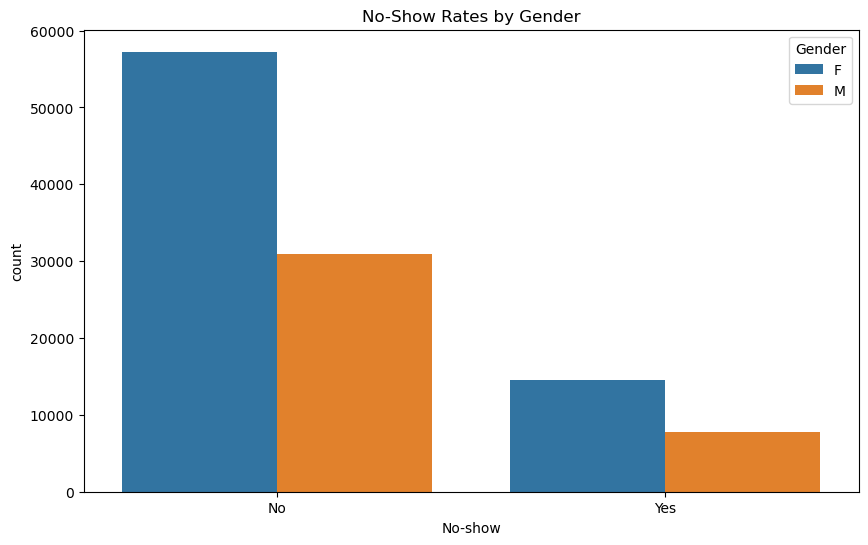

In [3]:
# Analyze the relationship between patient characteristics and no-show rates
print(df['No-show'].value_counts())

# Visualize key patterns
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='No-show', hue='Gender')
plt.title('No-Show Rates by Gender')
plt.show()

# Handle categorical variables
df['No-show'] = df['No-show'].map({'No': 0, 'Yes': 1})  # Encode target variable
label_encoder = LabelEncoder()
df['Gender'] = label_encoder.fit_transform(df['Gender'])  # Encode gender

# Create relevant temporal features
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['TimeInterval'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days
df['DayOfWeek'] = df['AppointmentDay'].dt.dayofweek
df['HourOfDay'] = df['ScheduledDay'].dt.hour

## 2. Feature Engineering

In [6]:
# Create patient history features
patient_history = df.groupby('PatientId').agg({
    'No-show': ['sum', 'count']
}).reset_index()
patient_history.columns = ['PatientId', 'PriorNoShows', 'TotalAppointments']
df = df.merge(patient_history, on='PatientId', how='left')

# Identify non-numeric columns
non_numeric_columns = X.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_columns)

# Apply one-hot encoding to categorical variables
X = pd.get_dummies(X, columns=non_numeric_columns, drop_first=True)

# Verify that all columns are numeric
print("Data types after encoding:")
print(X.dtypes)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the shapes of the resampled data
print("Resampled feature matrix shape:", X_resampled.shape)
print("Resampled target vector shape:", y_resampled.shape)

Non-numeric columns: Index(['Neighbourhood'], dtype='object')
Data types after encoding:
PatientId                      float64
Gender                           int32
Age                              int64
Scholarship                      int64
Hipertension                     int64
                                ...   
Neighbourhood_SÃO JOSÉ            bool
Neighbourhood_SÃO PEDRO           bool
Neighbourhood_TABUAZEIRO          bool
Neighbourhood_UNIVERSITÁRIO       bool
Neighbourhood_VILA RUBIM          bool
Length: 94, dtype: object
Resampled feature matrix shape: (176416, 94)
Resampled target vector shape: (176416,)


## 3. Classification Model Development

In [7]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train classifiers
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} Classification Report:")
    print(classification_report(y_test, y_pred))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.91      0.93     17648
           1       0.91      0.96      0.94     17636

    accuracy                           0.94     35284
   macro avg       0.94      0.94      0.94     35284
weighted avg       0.94      0.94      0.94     35284

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     17648
           1       0.00      0.00      0.00     17636

    accuracy                           0.50     35284
   macro avg       0.25      0.50      0.33     35284
weighted avg       0.25      0.50      0.33     35284

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93     17648
           1       0.90      0.97      0.93     17636

    accuracy                           0.93     35284
   macr

## 4. Patient Segmentation

In [9]:
# Exclude non-numeric columns before profiling clusters
numeric_columns = df.select_dtypes(include=[np.number]).columns
print("Numeric columns included in clustering:")
print(numeric_columns)

# Group by cluster and compute mean only for numeric columns
cluster_profiles = df.groupby('Cluster')[numeric_columns].mean()
print("Cluster Profiles:")
print(cluster_profiles)

Numeric columns included in clustering:
Index(['PatientId', 'Gender', 'Age', 'Scholarship', 'Hipertension', 'Diabetes',
       'Alcoholism', 'Handcap', 'SMS_received', 'No-show', 'TimeInterval',
       'DayOfWeek', 'HourOfDay', 'PriorNoShows_x', 'TotalAppointments_x',
       'PriorNoShows_y', 'TotalAppointments_y', 'PriorNoShows',
       'TotalAppointments', 'Cluster'],
      dtype='object')
Cluster Profiles:
            PatientId    Gender        Age  Scholarship  Hipertension  \
Cluster                                                                 
0        4.089149e+14  0.351718  36.804917     0.096734      0.200019   
1        3.202698e+13  0.348646  37.140643     0.099252      0.198222   
2        8.066822e+14  0.359207  36.948106     0.091982      0.187048   

         Diabetes  Alcoholism   Handcap  SMS_received   No-show  TimeInterval  \
Cluster                                                                         
0        0.073571    0.024017  0.021454      0.327891  0.20

## 5. Model Evaluation and Improvement

Random Forest Confusion Matrix:
[[16036  1612]
 [  645 16991]]


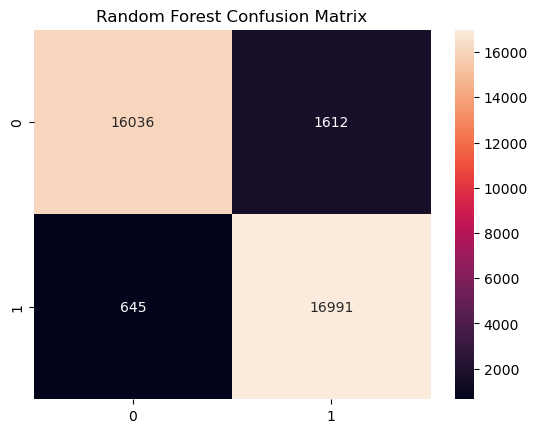

Logistic Regression Confusion Matrix:
[[17648     0]
 [17636     0]]


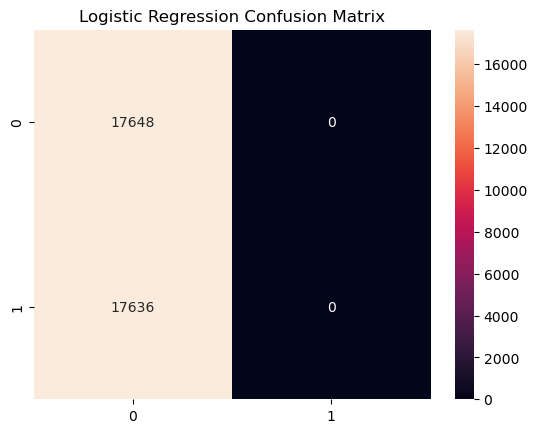

Gradient Boosting Confusion Matrix:
[[15742  1906]
 [  566 17070]]


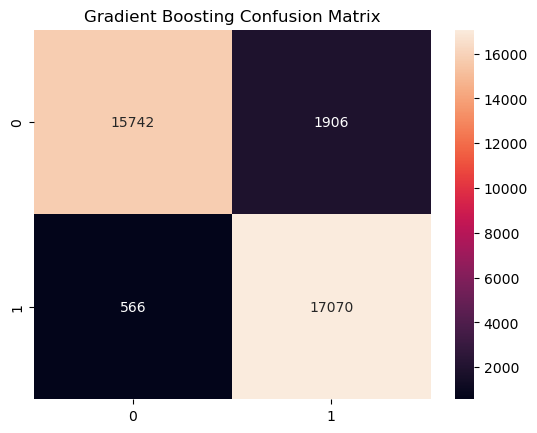

In [10]:
# Analyze confusion matrices
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print(f"{name} Confusion Matrix:")
    print(cm)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f"{name} Confusion Matrix")
    plt.show()

## 6. Feature Importance Analysis

Explained Variance Ratio: 1.0000


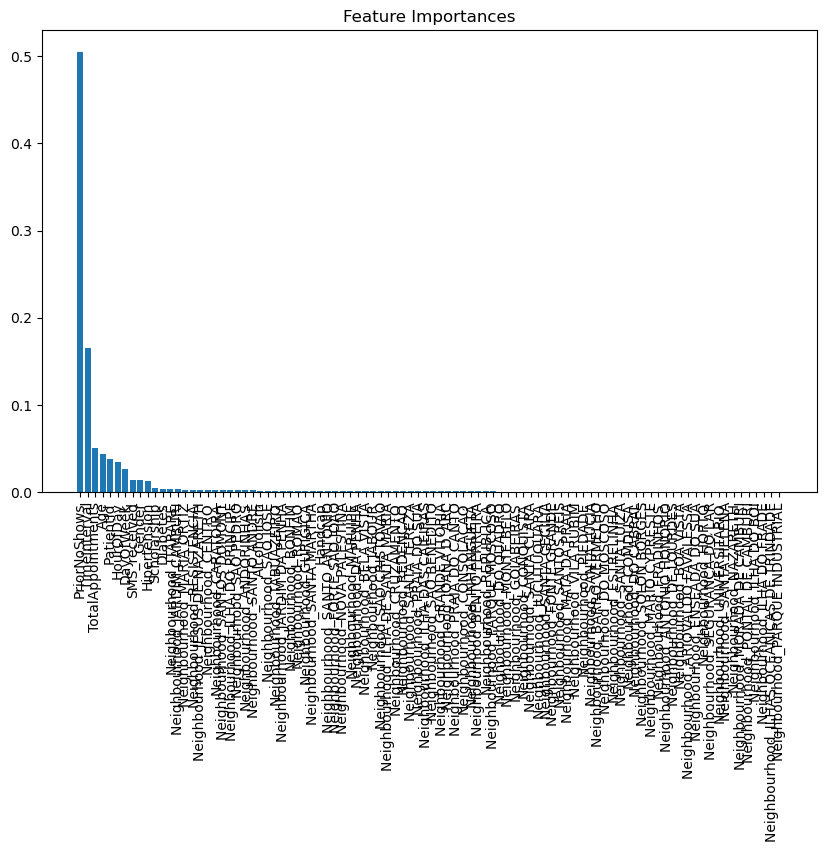

In [11]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)
print(f"Explained Variance Ratio: {np.sum(pca.explained_variance_ratio_):.4f}")

# Feature importance using Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.show()

## Conclusion
This notebook demonstrates the implementation of a predictive model for healthcare appointment no-show prediction. It includes data exploration, feature engineering, classification, clustering, and feature importance analysis. The insights gained can help the clinic implement targeted interventions to improve appointment adherence.